In [14]:

from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

%matplotlib inline
sns.set(style="whitegrid", font_scale=1.0)

# create output dirs
Path("output/plots").mkdir(parents=True, exist_ok=True)
Path("reports").mkdir(parents=True, exist_ok=True)


In [15]:
# --- cell ---
# Find and read parquet (prefer pandas/pyarrow; minimal fallback)
from pathlib import Path
from pyspark.sql import SparkSession

def find_parquet(start=Path.cwd(), name="ott_combined.parquet"):
    p = Path(start)
    for _ in range(6):
        candidate = p / "data" / "processed" / name
        if candidate.exists():
            return candidate.resolve()
        p = p.parent
    for candidate in Path(start).rglob(name):
        if candidate.is_dir() and "processed" in candidate.parts:
            return candidate.resolve()
    return None

parquet_dir = find_parquet()
if parquet_dir is None:
    raise FileNotFoundError("Parquet not found: data/processed/ott_combined.parquet. Run Modules 1+2 with correct mounts.")

# prefer pandas
try:
    df = pd.read_parquet(parquet_dir)
    engine = "pandas"
except Exception:
    spark = SparkSession.builder.appName("OTTAnalysis").master("local[*]").getOrCreate()
    df = spark.read.parquet(str(parquet_dir))
    engine = "spark"

print("Engine:", engine)


Engine: pandas


In [ ]:

# Minimal cleaning & normalization (keeps memory small)
if engine == "pandas":
    pdf = df.copy()
    # unify column name
    if "listed_in" in pdf.columns and "genre" not in pdf.columns:
        pdf = pdf.rename(columns={"listed_in":"genre"})
    # keep only needed columns if present
    keep = [c for c in ["platform","type","title","country","genre","release_year"] if c in pdf.columns]
    pdf = pdf[keep].fillna("Unknown")
    # numeric year
    if "release_year" in pdf.columns:
        pdf["release_year"] = pd.to_numeric(pdf["release_year"], errors="coerce")
    print("Loaded pandas:", pdf.shape)
else:
    sdf = df
    if "listed_in" in sdf.columns and "genre" not in sdf.columns:
        sdf = sdf.withColumnRenamed("listed_in","genre")
    print("Loaded Spark DF")


Loaded pandas: (18478, 6)


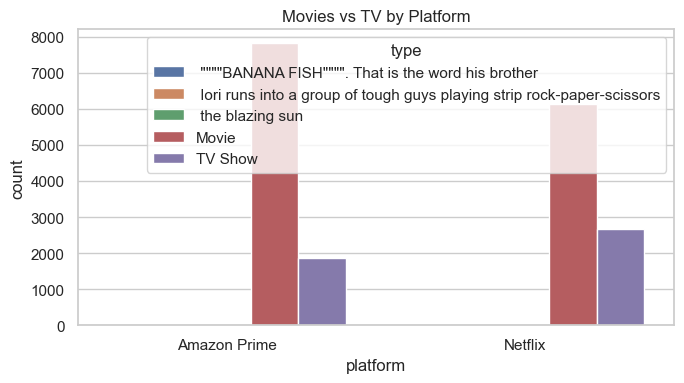

In [17]:
# --- cell ---
# PLOT 1: Movies vs TV Shows per platform
plt.figure(figsize=(7,4))
if engine == "pandas":
    if "type" in pdf.columns:
        tmp = pdf.groupby(["platform","type"]).size().reset_index(name="count")
        sns.barplot(data=tmp, x="platform", y="count", hue="type")
    else:
        print("Missing 'type' column")
else:
    if "type" in sdf.columns:
        tmp = sdf.groupBy("platform","type").count().toPandas()
        sns.barplot(data=tmp, x="platform", y="count", hue="type")
    else:
        print("Missing 'type' column")
plt.title("Movies vs TV by Platform")
plt.tight_layout()
plt.savefig("output/plots/01_movies_vs_tv.png", dpi=150)
plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_24328\2314917654.py:15: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  topn = top.groupby("platform").apply(lambda x: x.nlargest(8,"count")).reset_index(drop=True)


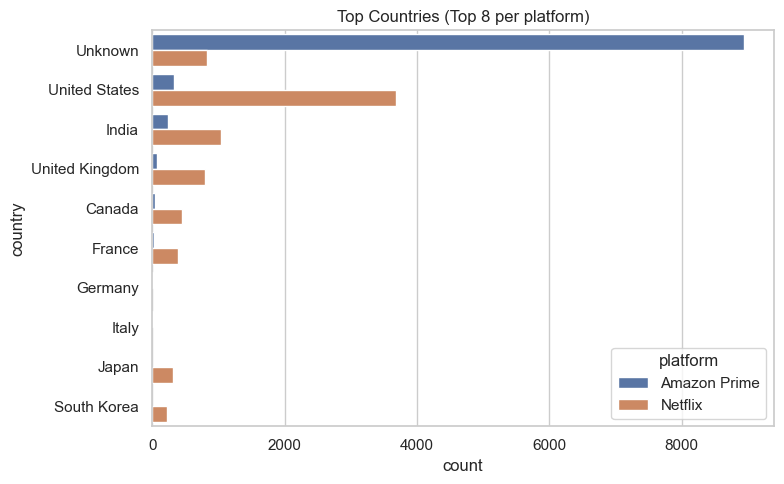

In [ ]:

# PLOT 2: Top 8 countries per platform (explode comma lists)
plt.figure(figsize=(8,5))
def explode_pandas(df, col):
    s = df[[col,"platform"]].copy()
    s[col] = s[col].astype(str).fillna("Unknown")
    s = s.assign(**{col: s[col].str.split(",")})
    s = s.explode(col)
    s[col] = s[col].str.strip()
    return s

if engine == "pandas" and "country" in pdf.columns:
    ce = explode_pandas(pdf, "country")
    top = ce.groupby(["platform","country"]).size().reset_index(name="count")
    topn = top.groupby("platform").apply(lambda x: x.nlargest(8,"count")).reset_index(drop=True)
    sns.barplot(data=topn, x="count", y="country", hue="platform")
elif engine=="spark" and "country" in sdf.columns:
    from pyspark.sql.functions import split, explode, trim, col as spark_col
    dfc = sdf.withColumn("country", explode(split(spark_col("country"), ","))).withColumn("country", trim(spark_col("country")))
    top = dfc.groupBy("platform","country").count().toPandas()
    topn = top.groupby("platform").apply(lambda x: x.nlargest(8,"count")).reset_index(drop=True)
    sns.barplot(data=topn, x="count", y="country", hue="platform")
else:
    print("Missing 'country' column")
plt.title("Top Countries (Top 8 per platform)")
plt.tight_layout()
plt.savefig("output/plots/02_top_countries.png", dpi=150)
plt.show()


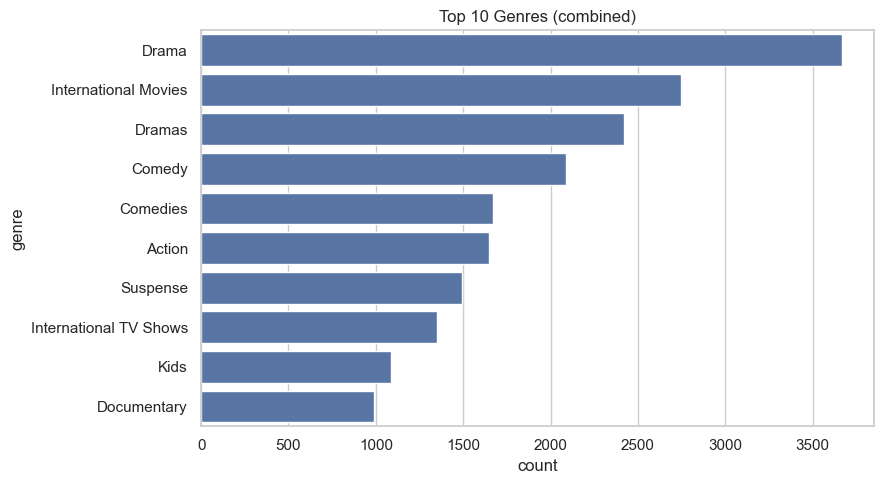

In [ ]:

# PLOT 3: Top genres (top 10 combined)
plt.figure(figsize=(9,5))
if engine == "pandas" and "genre" in pdf.columns:
    ge = explode_pandas(pdf, "genre")
    top_gen = ge['genre'].value_counts().head(10).reset_index()
    top_gen.columns = ["genre","count"]
    sns.barplot(data=top_gen, x="count", y="genre")
elif engine=="spark" and "genre" in sdf.columns:
    from pyspark.sql.functions import split, explode, trim, col as spark_col
    dfg = sdf.withColumn("genre", explode(split(spark_col("genre"), ","))).withColumn("genre", trim(spark_col("genre")))
    top_gen = dfg.groupBy("genre").count().orderBy("count", ascending=False).limit(10).toPandas()
    sns.barplot(data=top_gen, x="count", y="genre")
else:
    print("Missing 'genre' column")
plt.title("Top 10 Genres (combined)")
plt.tight_layout()
plt.savefig("output/plots/03_top_genres.png", dpi=150)
plt.show()


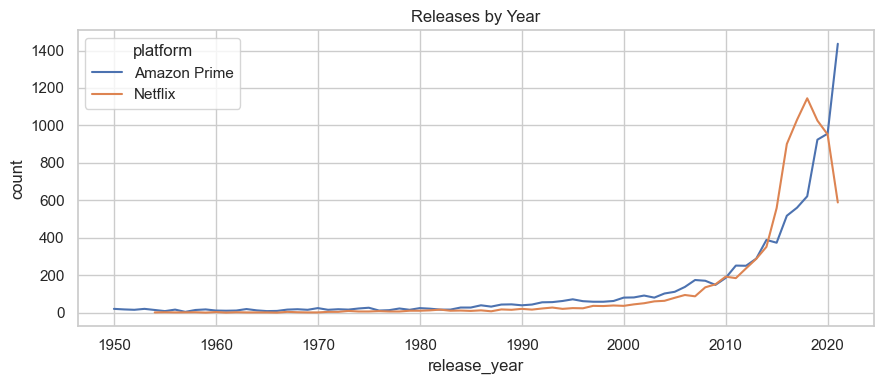

In [ ]:

# PLOT 4: Releases by year (filtered, clear)
plt.figure(figsize=(9,4))
if engine == "pandas" and "release_year" in pdf.columns:
    yrs = pdf[pd.to_numeric(pdf["release_year"], errors="coerce").notna()].copy()
    yrs["release_year"] = yrs["release_year"].astype(int)
    yrs = yrs[(yrs["release_year"]>=1950) & (yrs["release_year"]<=pd.Timestamp.now().year)]
    yearly = yrs.groupby(["release_year","platform"]).size().reset_index(name="count")
    sns.lineplot(data=yearly, x="release_year", y="count", hue="platform", estimator=None)
elif engine=="spark" and "release_year" in sdf.columns:
    sdfy = sdf.withColumn("release_year", sdf["release_year"].cast("int"))
    sdfy = sdfy.filter((sdfy["release_year"]>=1950) & (sdfy["release_year"]<=2025))
    yearly = sdfy.groupBy("release_year","platform").count().toPandas()
    sns.lineplot(data=yearly, x="release_year", y="count", hue="platform", estimator=None)
else:
    print("Missing 'release_year' column")
plt.title("Releases by Year")
plt.tight_layout()
plt.savefig("output/plots/04_releases_by_year.png", dpi=150)
plt.show()


In [21]:

lines = []
if engine == "pandas":
    lines.append(f"Total titles: {len(pdf)}")
    lines.append("Counts by platform:")
    lines.append(pdf['platform'].value_counts().to_string())
else:
    lines.append(f"Total titles (spark): {sdf.count()}")
    lines.append("Counts by platform (spark):")
    lines.append(sdf.groupBy("platform").count().toPandas().to_string(index=False))

with open("reports/summary.txt","w",encoding="utf-8") as f:
    f.write("\n".join(lines))

print("Done — plots in output/plots/, summary in reports/summary.txt")


Done — plots in output/plots/, summary in reports/summary.txt
